In [1]:
#from spatial_metabolic_distribution import Maps, MetabolicPropertyMapsAssembler
from spectral_spatial_simulation import Model as SpectralSpatialModel
from spectral_spatial_simulation import FID
from sampling import Model as SamplingModel
from matplotlib.pyplot import legend, title
import matplotlib.pyplot as plt
from display import plot_FID
from easygraph import Graph
#from printer import Console
from prettyconsole import Console
import dask.array as da
import numpy as np
import cupy as cp
import os.path
import tools
import dask
import pint
import file
import h5py
import sys

from tqdm import tqdm
import warnings

# Both required for the JupyterPlotManager
from tools import JupyterPlotManager
%matplotlib ipympl

# For e.g., storing to disk (dask.to_zarr)
from tools import DaskTools

# For some incomplete data
from spatial_metabolic_distribution import ParameterMap, ParameterVolume

In [2]:
# Initialise the UnitRegistry
u = pint.UnitRegistry()

# Check number of reserved CPUs and total available CPUs

In [3]:
print("available number of CPUs for this simulation (vary if reserved):")
!nproc

available number of CPUs for this simulation (vary if reserved):
40


In [4]:
print("all logical CPUs on the system:")
!nproc --all

all logical CPUs on the system:
40


# Check current GPU load & Define GPU(s) for small and big tasks

In [5]:
# Set generally visible GPU devices

!nvidia-smi

Fri Jan 30 10:54:16 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.274.02             Driver Version: 535.274.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-DGXS-32GB           On  | 00000000:07:00.0 Off |                    0 |
| N/A   33C    P0              37W / 300W |     55MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3"

#target_gpu_smaller_tasks = 2
#target_gpus_big_tasks = [3]

target_gpu_smaller_tasks = 2
target_gpus_big_tasks = [1,2,3]

device_memory_limit = "32GB"

# Check free RAM

In [7]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:           251Gi        13Gi       217Gi        18Mi        19Gi       235Gi
Swap:             0B          0B          0B


# <span style="color:red">Define Simulation paramaters (TODO collect all important ones). Are they already base units?!</span>

In [8]:
TE=0.0013*u.s  # secound
TR=0.6*u.s     # secound
alpha=45*u.deg # degree

# Load defined paths in the configurator

In [9]:
config_file_name = "paths_09012026.json"

In [10]:
configurator = file.Configurator(path_folder="../config/",
                                 file_name=config_file_name)
configurator.load()

# Load metabolic mask

In [11]:
metabolic_mask = file.Mask(configurator=configurator)
metabolic_mask.load(mask_name="metabolites", data_type=np.float32)

[  1  ][ success ] ---v                       
                      Loaded file 'Vol_004_mask_slab.nii':
                          Shape             -> (112, 128, 80)
                          Pixel dimensions: -> (1.7188, 1.7188, 1.72)
                          Values range:     -> [0.0, 1.0]
                          Data type:        -> <class 'numpy.float32'>
                          In memory cache?  -> True
[  2  ][ success ] >> Thus, loaded the 'metabolites' mask.                                                                 


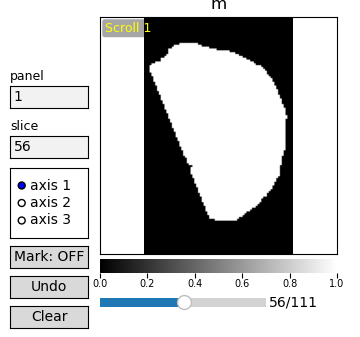

In [12]:
metabolic_mask.plot_jupyter()

# Load the FIDs

In [13]:
metabolites = file.FID(configurator=configurator)
metabolites.load(fid_name="metabolites", signal_data_type=np.complex64) # TODO TODO, here seems to be an issue => data type has no effect?
metabolites.loaded_fid.change_signal_data_type("complex64")
metabolites.loaded_fid.change_time_data_type("float32")

[  3  ][  info   ] ---v                       
                      Loaded FID signal as <class 'numpy.complex64'> 
                       -> thus using space: 264.0 KB 
                       -> thus using digits: 15
[  4  ][ success ] >> Transformed FID signal to complex values: (16896, 2) -> (16896,)                                     
[  5  ][ success ] ---v  (collected several lines)                      
                      Assigned FID parts:
                      0. Acetyl+Aspartyl_moi(NAAG) -----> shape: (1536,)
                      1. Choline_moi(GPC) --------------> shape: (1536,)
                      2. Creatine (Cr) -----------------> shape: (1536,)
                      3. Glutamate (Glu) ---------------> shape: (1536,)
                      4. Glutamate_moi(NAAG) -----------> shape: (1536,)
                      5. Glutamine_noNH2 (Gln) ---------> shape: (1536,)
                      6. Glycerol_moi(GPC) -------------> shape: (1536,)
                      7. MyoIno

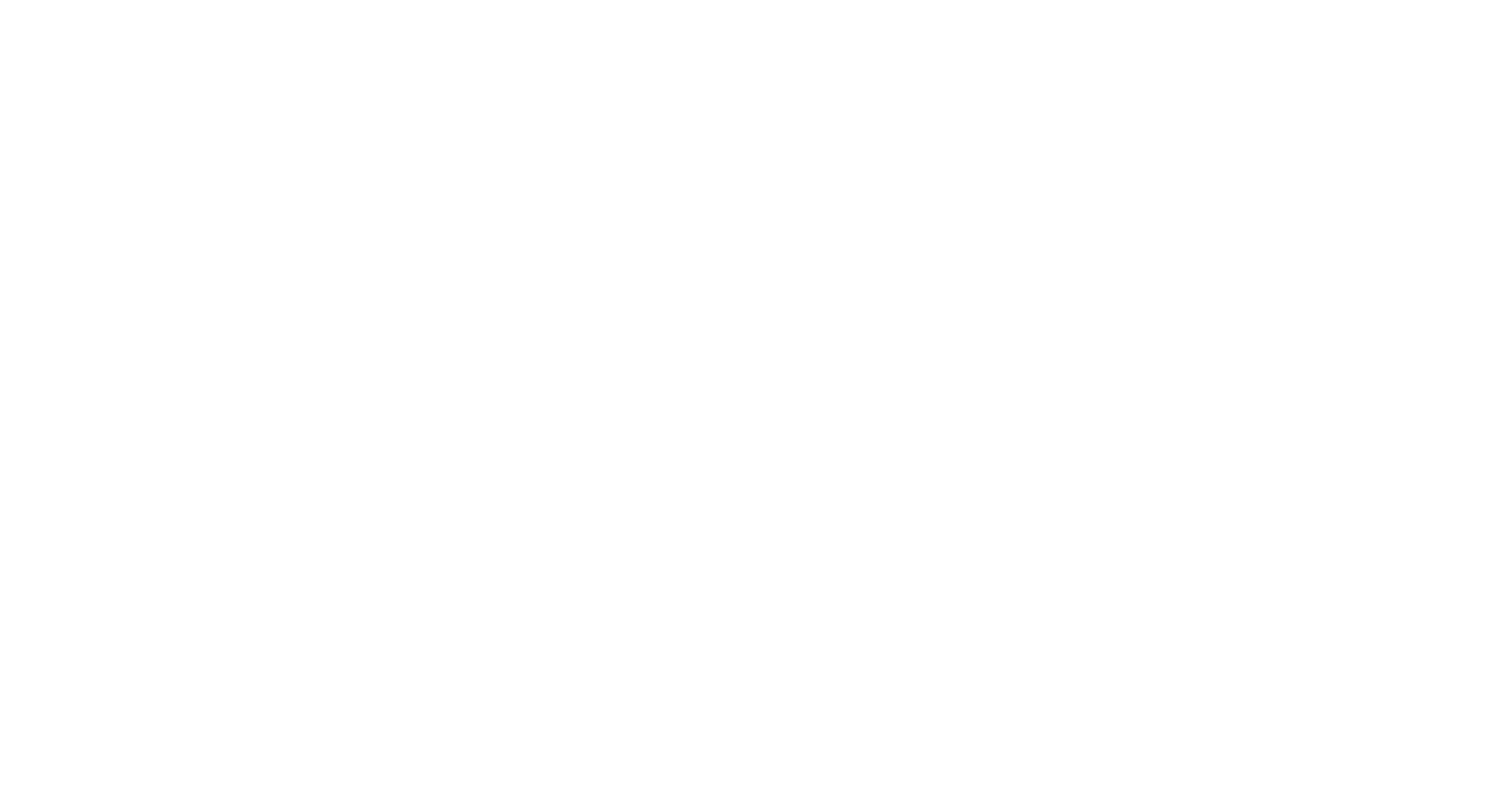

In [14]:
loaded_fid = metabolites.loaded_fid
loaded_fid.plot()

#### <span style="color:red">!!! Interpolate to 100.000 FID points for test purposes.</span>

In [15]:
loaded_fid.interpolate(timepoints=100_000)

[  9  ][ success ] ---v                       
                      Interpolated FID: 
                       => time shape:   (1536,)         --> (100000,) 
                       => signal shape: (11, 1536)      --> (11, 100000)


# Load and prepare the concentration maps

#### Load the desired concentration maps

In [16]:
loaded_concentration_maps = file.ParameterMaps(configurator=configurator, map_type_name="metabolites_concentration")
working_name_and_file_name = {"Glu": "MetMap_Glu_con_map_TargetRes_HiRes.nii",
                              "Gln": "MetMap_Gln_con_map_TargetRes_HiRes.nii",
                              "m-Ins": "MetMap_Ins_con_map_TargetRes_HiRes.nii",
                              "NAA": "MetMap_NAA_con_map_TargetRes_HiRes.nii",
                              "Cr+PCr": "MetMap_Cr+PCr_con_map_TargetRes_HiRes.nii",
                              "GPC+PCh": "MetMap_GPC+PCh_con_map_TargetRes_HiRes.nii",
                             }
loaded_concentration_maps.load_files_from_folder(working_name_and_file_name=working_name_and_file_name)

[ 10  ][  info   ] >> Maps object: The provided path points to a folder                                                    
[ 11  ][ warning ] >> Maps.load_files_from_folder ==> by standard nii is loaded. No h5 support yet!                        
[ 12  ][ warning ] >> The same unit is assumed for all the files in the given folder!                                      
[ 13  ][ success ] ---v  (collected several lines)                      
                      Loaded maps: 
                        0: working name: .......Glu | Shape:   (440, 440, 266) | Values range: [0.0, 42.733] | Unit: millimole |
                        1: working name: .......Gln | Shape:   (440, 440, 266) | Values range: [0.0, 41.138] | Unit: millimole |
                        2: working name: .....m-Ins | Shape:   (440, 440, 266) | Values range: [0.0, 40.316] | Unit: millimole |
                        3: working name: .......NAA | Shape:   (440, 440, 266) | Values range: [0.0, 42.934] | Unit: millimole |
   

#### Convert to base units and display loaded data

[ 14  ][ success ] >> Converted to base units: millimole -> mole                                                           


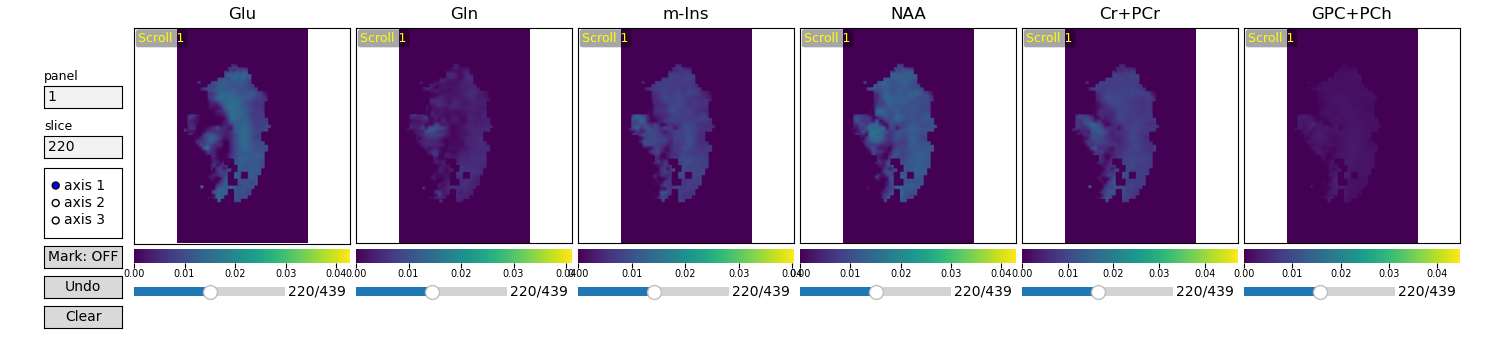

In [17]:
# Convert to base units (e.g., mmol to mol)
loaded_concentration_maps.to_base_units()
# Display the data
import time
time.sleep(1)
loaded_concentration_maps.plot_jupyter(cmap="viridis")

#### Create 4D array from the 3D arrays and interpolate to target shape

In [18]:
# Convert the file.Maps object to a ParamaterVolume of shape (metabolite, X, Y, Z) & change to float32
concentration_volume = loaded_concentration_maps.to_working_volume(data_type="float32")

# Interpolate to the shape of the 
concentration_volume.interpolate(target_size=metabolic_mask.mask.shape, order=3, device="gpu", target_gpu=target_gpu_smaller_tasks, verbose=False)

[ 15  ][ success ] ---v                       
                      Created 4D volume of metabolite maps: ['Glu', 'Gln', 'm-Ins', 'NAA', 'Cr+PCr', 'GPC+PCh']. 
                       Map type: ....... metabolites_concentration 
                       Unit: ........... mole 
                       Shape: .......... (6, 440, 440, 266) 
                       Data type: ...... float64 
                       Space: .......... 2357.4 mebibyte
[ 16  ][ success ] >> Changed the data type from float64 (2357.4 mebibyte) -> float32 (1178.7 mebibyte)                    
[ 17  ][  info   ] >> Interpolate on GPU: 2                                                                                


# Load and prepare the T1 maps
### <span style="color:red">!!! Only one T1 map is loaded at the moment and used for each metabolite.</span>

#### <span style="color:red">!!! Load only one t1 maps and then convert to base units.</span>

In [19]:
loaded_t1_map = file.ParameterMaps(configurator=configurator, map_type_name="T1")
loaded_t1_map.load_file()
loaded_t1_map.to_base_units()

[ 18  ][  info   ] >> Maps object: The provided path points to a file                                                      
[ 19  ][  info   ] >> Loading nii file for map type T1                                                                     
[ 20  ][ success ] ---v  (collected several lines)                      
                      Loaded nii map: T1_TargetRes_HiRes.nii | Shape: (440, 440, 266) | Values range: [-327.493, 4848.004] | Unit: millisecond | Unique values: 888245
                      
[ 21  ][ success ] >> Converted to base units: millisecond -> second                                                       


#### <span style="color:red">!!! Assemble pseudo 4D array of T1 maps (same for each metabolite).</span>

In [20]:
t1_volume = ParameterVolume(maps_type="T1")

for metabolite in concentration_volume.metabolites:
    parameter_map = ParameterMap(map_type=loaded_t1_map.map_type_name, metabolite_name=metabolite, values=loaded_t1_map.loaded_maps, unit=loaded_t1_map.loaded_maps_unit)
    t1_volume.add_map(parameter_map)

t1_volume.to_volume()
t1_volume.interpolate(target_size=metabolic_mask.mask.shape, order=3, device="gpu", target_gpu=target_gpu_smaller_tasks, verbose=False)
t1_volume.to_data_type("float32")

[ 22  ][ success ] ---v                       
                      Created 4D volume of metabolite maps: ['Glu', 'Gln', 'm-Ins', 'NAA', 'Cr+PCr', 'GPC+PCh']. 
                       Map type: ....... T1 
                       Unit: ........... second 
                       Shape: .......... (6, 440, 440, 266) 
                       Data type: ...... float64 
                       Space: .......... 2357.4 mebibyte
[ 23  ][  info   ] >> Interpolate on GPU: 2                                                                                
[ 24  ][ success ] >> Changed the data type from float64 (52.5 mebibyte) -> float32 (26.25 mebibyte)                       


In [21]:
np.min(t1_volume.volume)

-0.5247435

#### <span style="color:red">!!! TODO TODO TODO TODO: Maybe implement this function?.</span>

In [22]:
##print(np.min(t1_volume.volume))
##print((t1_volume.volume == 0).sum())
###t1_volume.volume = tools.ArrayTools.negative_to_eps(t1_volume.volume)
##
##import numpy as np
##
##def count_zero_and_near_zero(t1, eps=1e-6):
##    """
##    Count exact zeros and near-zeros in a NumPy array.
##    """
##    t1 = np.asarray(t1)
##
##    n_total = t1.size
##    n_zero = np.count_nonzero(t1 == 0)
##    n_near = np.count_nonzero((np.abs(t1) < eps) & (t1 != 0))
##
##    return {
##        "total": int(n_total),
##        "zero_count": int(n_zero),
##        "zero_percent": 100.0 * n_zero / n_total if n_total else 0.0,
##        "near_zero_count": int(n_near),
##        "near_zero_percent": 100.0 * n_near / n_total if n_total else 0.0,
##        "eps": float(eps),
##        "min_abs": float(np.min(np.abs(t1))) if n_total else float("nan"),
##    }
##
##stats = count_zero_and_near_zero(t1_volume.volume, eps=1e-6)
##print(stats)

#from tools import ArrayTools
#t1_volume.volume = ArrayTools.negative_to_eps(array=t1_volume.volume)

#np.min(t1_volume.volume)

In [23]:
from tools import ArrayTools
ArrayTools.check_nan(t1_volume.volume)
ArrayTools.count_zeros(t1_volume.volume)

[ 25  ][  info   ] >> Found number of zeros: 0                                                                             


0

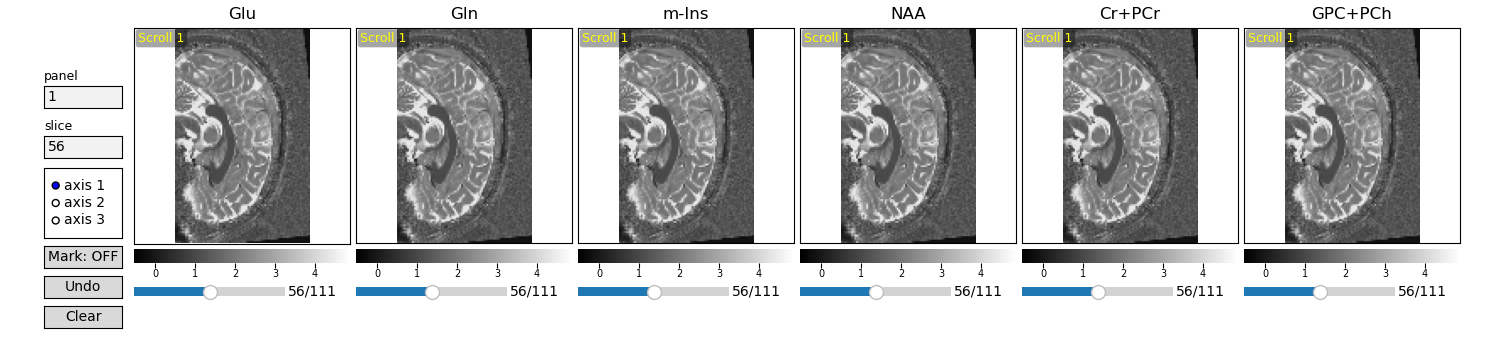

In [24]:
t1_volume.display_jupyter(display="volume")

# Load and prepare the T2 maps

#### <span style="color:red">!!! The reference where T2 vales ares used from. Only homogenious at the moment.</span>

In [25]:
# Using T2 values from:
cm = tools.CitationManager("../docs/references.bib")
cm.cite("versteeg2024high")
# But also see:
cm.cite("seginer2022phase")

t2_WM = (25+39)/2*u.ms
t2_GM = (33+55)/2*u.ms

t2_GM_WM_average = (t2_WM+t2_GM)/2
t2_GM_WM_average = t2_GM_WM_average.to_base_units()

t2_GM_WM_average
# Do I have GM and WM segmentation?

<Quantity(0.038, 'second')>

In [26]:
t2_volume = ParameterVolume(maps_type="T2")

for metabolite in concentration_volume.metabolites:
    parameter_map = ParameterMap(map_type="T2", metabolite_name=metabolite, values=np.full(metabolic_mask.mask.shape, t2_GM_WM_average), unit=t2_GM_WM_average.units)
    t2_volume.add_map(parameter_map)

t2_volume.to_volume()
t2_volume.to_data_type("float32")
#t2_volume.interpolate_volume(target_size=metabolic_mask.mask.shape, order=3, device="gpu", target_gpu=target_gpu_smaller_tasks, verbose=False)

[ 26  ][ success ] ---v                       
                      Created 4D volume of metabolite maps: ['Glu', 'Gln', 'm-Ins', 'NAA', 'Cr+PCr', 'GPC+PCh']. 
                       Map type: ....... T2 
                       Unit: ........... second 
                       Shape: .......... (6, 112, 128, 80) 
                       Data type: ...... float64 
                       Space: .......... 52.5 mebibyte
[ 27  ][ success ] >> Changed the data type from float64 (52.5 mebibyte) -> float32 (26.25 mebibyte)                       


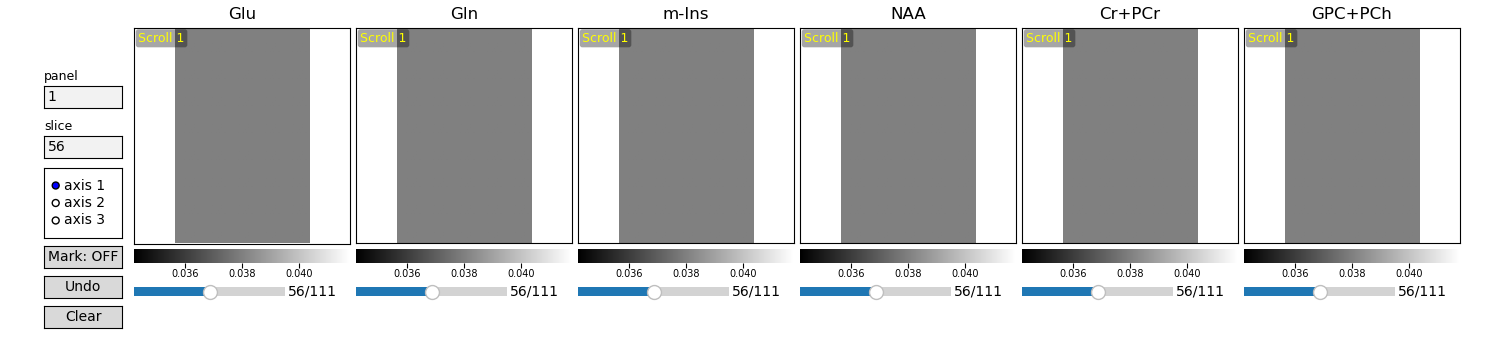

In [27]:
import time
time.sleep(2)
t2_volume.display_jupyter()

# Use desired FID signals and merge some of them

In [28]:
using_fid_signals = ["Glutamate (Glu)",
                     "Glutamine_noNH2 (Gln)",
                     "MyoInositol (m-Ins)",
                     "NAcetylAspartate (NAA)",
                     "Creatine (Cr)",
                     "Phosphocreatine (PCr)",
                     "Choline_moi(GPC)",
                     "Glycerol_moi(GPC)",
                     "PhosphorylCholine_new1 (PC)"]

In [29]:
# Take a subset of all signals of the FID. This returns a new FID object.
fid = loaded_fid.get_partly_fid(using_fid_signals)

# Merge signals of the FID in order to match the Maps
fid.merge_signals(names=["Creatine (Cr)", "Phosphocreatine (PCr)"],
                  new_name="Cr+PCr",
                  divisor=2)

fid.merge_signals(names=["Choline_moi(GPC)", "Glycerol_moi(GPC)", "PhosphorylCholine_new1 (PC)"],
                  new_name="GPC+PCh",
                  divisor=2)

fid.name = fid.get_name_abbreviation()

[ 28  ][ success ] ---v  (automatic line breaks) 
                      Merged signals of ['Creatine (Cr)', 'Phosphocreatine (PCr)'] with factor 1/2. New name of signal:
                      Cr+PCr
[ 29  ][ success ] ---v  (automatic line breaks) 
                      Merged signals of ['Choline_moi(GPC)', 'Glycerol_moi(GPC)', 'PhosphorylCholine_new1 (PC)'] with
                      factor 1/2. New name of signal: GPC+PCh


# Create Spectral-Spatial Model (Spectral-spatial combination)

Incorporating the T1 and T2 effects: T1 transform the signal height (Recovery). Thus bigger T1 or shorter TR -> less signal. T2 dampens the signal, this bigger T2 -> slower decay. Bigger T2 -> faste decay (less signal)

T1-transform:
$V_{\text{out}} = V_{\text{in}} \, \sin(\alpha)\, \frac{1 - e^{-TR/T_1}}{1 - \cos(\alpha)\, e^{-TR/T_1}}$

T2-transform:
$V_{\text{out}} = V_{\text{in}} \, e^{-\frac{TE + t}{T_2}}$


#### Ensure that each map has the same order

In [30]:
# (1) Ensure that the metabolite order is the same for all volumes
desired_order = ['Glu', 'Gln', 'm-Ins', 'NAA', 'Cr+PCr', 'GPC+PCh']
concentration_volume.reorder_metabolites(desired_order)
t1_volume.reorder_metabolites(desired_order)
t2_volume.reorder_metabolites(desired_order)

[ 30  ][ warning ] >> No sorting is applied since already desired order is given!                                          
[ 31  ][ warning ] >> No sorting is applied since already desired order is given!                                          
[ 32  ][ warning ] >> No sorting is applied since already desired order is given!                                          


#### Create the model

In [31]:
block_size = (int(35), int(112), int(128), int(80))

spectral_spatial_model = SpectralSpatialModel(path_cache=configurator.data["cache"],
                                              block_size=block_size,  # Note, also possible: 1536x10x10x10
                                              TE=TE,
                                              TR=TR,
                                              alpha=alpha,
                                              data_type="complex64",
                                              compute_on_device="gpu",
                                              return_on_device="gpu") # TODO: When doing here cpu next part then cuda has issue!


# Add all the parameter maps (spatial)
spectral_spatial_model.add_parameter_volume("T1", t1_volume)
spectral_spatial_model.add_parameter_volume("T2", t2_volume)
spectral_spatial_model.add_parameter_volume("concentration", concentration_volume)
spectral_spatial_model.add_mask(metabolic_mask.mask.data)                       # Mask of brain

# Add the FID signals (spectral)
#fid.time = fid.time * u.s # to add seconds # TODO
spectral_spatial_model.add_fid(fid)                                             # Add FID (all separate signals summed up)

spectral_spatial_model.model_summary()

[ 33  ][ warning ] >> The T1 volume exhibits zero and/or negative values: -0.5247434973716736                              
[ 34  ][ success ] >> Converted negative and zero values to eps: 1.1920928955078125e-07                                    
[ 35  ][ success ] >> Added T1 to the Spectral Spatial Model.                                                              
[ 36  ][ success ] >> Added T2 to the Spectral Spatial Model.                                                              
[ 37  ][ warning ] >> The concentration volume exhibits negative values: -0.004001666326075792                             
[ 38  ][ success ] >> Converted negative values to eps: 1.1920928955078125e-07                                             
[ 39  ][ success ] >> Added concentration to the Spectral Spatial Model.                                                   
[ 40  ][ success ] >> Added mask to the spectral spatial model.                                                            
[ 41  ][

In [32]:
# To just check the data types
print("fid signal:", spectral_spatial_model.fid.signal.dtype)
print("fid time:", spectral_spatial_model.fid.time.dtype)
print("mask:", spectral_spatial_model.mask.dtype)
print("T1:", spectral_spatial_model.parameter_volumes["T1"].volume.dtype)
print("T2:", spectral_spatial_model.parameter_volumes["T2"].volume.dtype)
print("concentration:", spectral_spatial_model.parameter_volumes["concentration"].volume.dtype)

fid signal: complex64
fid time: float32
mask: float32
T1: float32
T2: float32
concentration: float32


In [33]:
computational_graph_0 = spectral_spatial_model.assemble_graph()
computational_graph_0

[ 43  ][  info   ] >> Start to assemble whole graph on device gpu                                                          


dask.array<to_device, shape=(100000, 112, 128, 80), dtype=complex64, chunksize=(35, 112, 128, 80), chunktype=cupy.ndarray>

In [34]:
computational_graph_0[0:1000,:,:,:]

dask.array<getitem, shape=(1000, 112, 128, 80), dtype=complex64, chunksize=(35, 112, 128, 80), chunktype=cupy.ndarray>

In [35]:
### # 1) Start Cluster
### cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
### #cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
### #WORKS on DL: 
### cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")
### 
### #------------------------------------------------
### Console.start_timer()
### 
### #test_gpu = test_graph[0,0:1000,:,:,:].compute()
### spectral_spatial_volume = computational_graph_0[0:1000,:,:,:].compute()
### 
### 
### Console.stop_timer()
### #------------------------------------------------
### 
### # 3) Close client and cluster
### cluster.close()

In [36]:
### from tools import ArrayTools
### ArrayTools.check_nan(spectral_spatial_volume.get())

In [37]:
# TODO Check the model pint quantities:
print(type(spectral_spatial_model.fid.time))
print(type(spectral_spatial_model.fid.signal))
print(type(spectral_spatial_model.mask))
print(type(spectral_spatial_model.alpha))
print(type(spectral_spatial_model.TE))
print(type(spectral_spatial_model.TR))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.memmap'>
<class 'pint.Quantity'>
<class 'pint.Quantity'>
<class 'pint.Quantity'>


In [38]:
metabolic_mask.mask.data.shape

(112, 128, 80)

In [39]:
computational_graph_0[0:100, :, :, :]

dask.array<getitem, shape=(100, 112, 128, 80), dtype=complex64, chunksize=(35, 112, 128, 80), chunktype=cupy.ndarray>

In [40]:
### ### TODO: Check the data of the spectral spatial model! ARE HERE NANS?
### 
### # 1) Start Cluster
### cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
### #cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
### #WORKS on DL: 
### cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")
### 
### #------------------------------------------------
### Console.start_timer()
### 
### #test_gpu = test_graph[0,0:1000,:,:,:].compute()
### test_spectral_spatial_model =computational_graph_0[0:100, :, :, :].compute()
### 
### 
### Console.stop_timer()
### #------------------------------------------------
### 
### # 3) Close client and cluster
### cluster.close()

In [41]:
### print(test_spectral_spatial_model.shape)
### print(test_spectral_spatial_model[:,60,60,20])
### 
### import matplotlib.pyplot as plt
### plt.figure()
### plt.imshow(np.abs(test_spectral_spatial_model[50,:,:,40]))
### plt.show()

In [42]:

#UU = da.fft.fftn(test_spectral_spatial_model, (-1,-2,-3))

# Sampling model

### Load the coil sensitivity maps

In [43]:
coil_sensitivity_maps_loader = file.CoilSensitivityMaps(configurator=configurator)
coil_sensitivity_maps_loader.load_h5py(keys=["imag", "real"], dtype=np.complex64)

[ 44  ][ success ] ---v  (collected several lines)                      
                      Coil Sensitivity Maps:
                       => Could find keys ['imag', 'real'] in the HDF5 file
                       => Loaded and converted maps to complex64
                       => Data shape: (32, 80, 86, 86)
                       => Space required: 144.45 mebibyte
                      


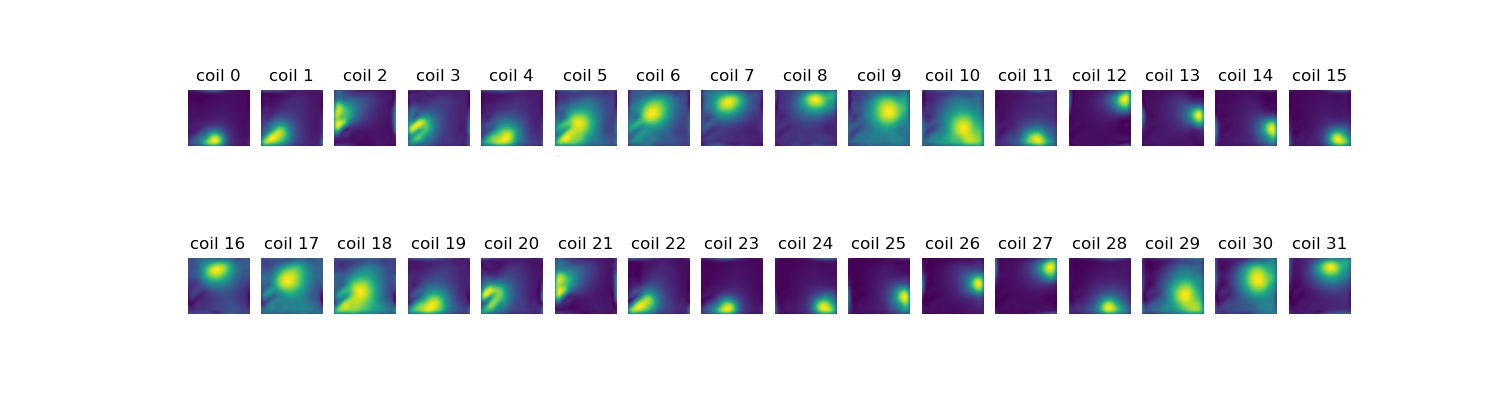

In [44]:
#coil_sensitivity_maps_loader.plot_jupyter(cmap="viridis")
coil_sensitivity_maps_loader.plot(cmap="viridis")

### Convert to working volume and interpolate

In [45]:
coil_sensitivity_volume = coil_sensitivity_maps_loader.to_working_volume()
coil_sensitivity_volume.interpolate(target_size=metabolic_mask.mask.shape, target_gpu=target_gpu_smaller_tasks)

[ 45  ][ success ] >> Transformed file.CoilSensitivityMaps => sampling.CoilSensitivityVolume                               
[ 46  ][  info   ] >> Preserving coil dimension during interpolation.                                                      
[ 47  ][  info   ] >> Interpolate on GPU: 2                                                                                
[ 48  ][ success ] ---v                       
                      Interpolated on gpu and returned on cpu 
                      Shape (32, 80, 86, 86) (144.453125 mebibyte) => (32, 112, 128, 80) (280.0 mebibyte)


### Create the sampling model & Apply the coil sensitivity maps

In [46]:
#block_size = (32, 35, 112, 128, 80)
block_size = (4, 35, 112, 128, 80)

#### TODO coil chunksize sollte nicht 32 sein!!!

sampling_model = SamplingModel(block_size=block_size, 
                               path_cache=configurator.data["cache"], 
                               data_type="complex64", 
                               coil_sensitivity_volume=coil_sensitivity_volume,
                               spectral_spatial_volume=computational_graph_0)

# TODO: Implement to print summary!!!! sampling_model.summary()

[ 49  ][  info   ] ---v  (collected several lines)                      
                      No slice to plot is specified. Choosing: 43
                      Transformed coil sensitivity volume of type '<class 'sampling.CoilSensitivityVolume'>' => dask array with chunksize: (4, 112, 128, 80)
                      


In [47]:
# Apply coil sensitivity maps
out_sampling_0 = sampling_model.apply_coil_sensitivity(compute_on_device="gpu", return_on_device="gpu")

[ 50  ][ success ] >> Added to apply coil sensitivity maps computational graph.                                            


In [48]:
out_sampling_0

dask.array<to_device, shape=(32, 100000, 112, 128, 80), dtype=complex64, chunksize=(4, 35, 112, 128, 80), chunktype=cupy.ndarray>

## FFT + FFT shift + crop center

In [49]:
# Here try tp use dask fft.fftn and check if it runs on gpu or cpu!

In [50]:
out_sampling_0_rechunked = out_sampling_0.rechunk(("auto", "auto", -1,-1,-1))#.rechunk({0: 1, 1: 1, 2: -1, 3: -1, 4: -1})
#out_sampling_0X = out_sampling_0X.astype("complex128")
print(out_sampling_0_rechunked.shape)
print(out_sampling_0_rechunked.shape[2:])
out_sampling_0_rechunked

(32, 100000, 112, 128, 80)
(112, 128, 80)


dask.array<rechunk-merge, shape=(32, 100000, 112, 128, 80), dtype=complex64, chunksize=(1, 13, 112, 128, 80), chunktype=cupy.ndarray>

In [51]:
out_sampling_0_rechunked_fft = da.fft.fftn(out_sampling_0_rechunked, axes=(2, 3, 4)) # out_sampling_0X.shape[2:]
#out_sampling_0_rechunked_fft = out_sampling_0_rechunked.map_blocks(cp.fft.fftn, axes=(2, 3, 4), dtype=cp.complex64)
out_sampling_0_rechunked_fft[16,0:100, :,:,:]

dask.array<getitem, shape=(100, 112, 128, 80), dtype=complex128, chunksize=(13, 112, 128, 80), chunktype=numpy.ndarray>

In [52]:
#out_sampling_0_rechunked_fft_shifted = da.fft.fftshift(out_sampling_0_rechunked_fft, axes=(2, 3, 4))
out_sampling_0_rechunked_fft_shifted = out_sampling_0_rechunked_fft.map_blocks(cp.fft.fftshift, axes=(2, 3, 4), dtype=cp.complex64)
out_sampling_0_rechunked_fft_shifted

dask.array<fftshift, shape=(32, 100000, 112, 128, 80), dtype=complex64, chunksize=(1, 13, 112, 128, 80), chunktype=cupy.ndarray>

In [53]:
## nun crop center und dann ifft => ganzes voluem!

def center_crop(a: da.Array, crop_center_shape=(64, 64, 40)) -> da.Array:
    # a.shape: (B, T, X, Y, Z)
    cx, cy, cz = crop_center_shape
    X, Y, Z = a.shape[-3:]  # may be ints or numpy ints; should be known for slicing

    if any(s is None for s in (X, Y, Z)):
        raise ValueError(
            "Center crop needs known sizes for X,Y,Z. "
            "If they're unknown, rechunk/load in a way that materializes the shape."
        )

    if cx > X or cy > Y or cz > Z:
        raise ValueError(f"Crop {crop_center_shape} larger than spatial shape {(X, Y, Z)}")

    sx = (X - cx) // 2
    sy = (Y - cy) // 2
    sz = (Z - cz) // 2

    return a[..., sx:sx+cx, sy:sy+cy, sz:sz+cz]

In [54]:
# cropped volume
k_space_crop_shape = (64, 64, 40)
out_sampling_1_fft_center = center_crop(out_sampling_0_rechunked_fft_shifted, k_space_crop_shape)
out_sampling_1_fft_center

dask.array<getitem, shape=(32, 100000, 64, 64, 40), dtype=complex64, chunksize=(1, 13, 64, 64, 40), chunktype=cupy.ndarray>

# TODO: Add gaussian NOISE. Certain SNR

In [55]:
# TODO: Compute based on seed voxel?

## IFFT

In [56]:
#out_sampling_0_rechunked_back = da.fft.ifftn(out_sampling_1_fft_center, axes=(2, 3, 4))
out_sampling_0_rechunked_back = out_sampling_1_fft_center.map_blocks(cp.fft.ifftn, axes=(2, 3, 4), dtype=cp.complex64)

In [57]:
out_sampling_0_rechunked_back[0, 0:1000,:,:,:]

dask.array<getitem, shape=(1000, 64, 64, 40), dtype=complex64, chunksize=(13, 64, 64, 40), chunktype=numpy.ndarray>

In [58]:
### # 1) Start Cluster
### cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
### #cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
### #WORKS on DL: 
### cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")
### 
### #------------------------------------------------
### Console.start_timer()
### 
### #test_gpu = test_graph[0,0:1000,:,:,:].compute()
### test_gpu = out_sampling_0_rechunked_back[0, 0:1000,:,:,:].compute()
### 
### 
### Console.stop_timer()
### #------------------------------------------------
### 
### # 3) Close client and cluster
### cluster.close()

In [59]:
# case 1:
#  dask fftn, ifftn
#  GPU Allocation: GPU1:28,GPU2:28,GPU3:32
#  time: 67 sec

# case 2:
#  map blocks cupy: fftn, ifftn
#  GPU Allocation: GPU1:28,GPU2:28,GPU:3:26
#  time: 98 sec 

In [60]:
#test_gpu.dtype

## COIL Combination

In [61]:
#### ALREADY START HERE CLUSTER, to have data on rigth gpu with persists:

# 1) Start Cluster
cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
#cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
#WORKS on DL: 
cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")

[ 51  ][ warning ] >> nvml diagnostics is disabled!                                                                        
[ 52  ][  info   ] >> Splitting large chunks is activated                                                                  


Unable to start CUDA Context
Traceback (most recent call last):
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/dask_cuda/initialize.py", line 31, in _create_cuda_context
    distributed.comm.ucx.init_once()
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/distributed/comm/ucx.py", line 133, in init_once
    cuda_visible_device = get_device_index_and_uuid(
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/distributed/diagnostics/nvml.py", line 256, in get_device_index_and_uuid
    device_handle = pynvml.nvmlDeviceGetHandleByIndex(device_index)
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/pynvml.py", line 2914, in nvmlDeviceGetHandleByIndex
    fn = _nvmlGetFunctionPointer("nvmlDeviceGetHandleByIndex_v2")
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/pynvml.py", line 1074, in _nvmlGetFunctionPointer
    raise NVMLError(NVML_ERROR_UNINITIALIZED)
pynvml.NVMLError_Uninitialized: Unini

[ 53  ][ success ] >> Started cuda Cluster 
 Link to dashboard: /proxy/55000/status                                        


In [62]:
#da.sum()

# wann dann coil combination?
from tools import GPUTools
import copy

# 1) Create dask array from coils sensitivity volume <- maybe before make conjugated complex <- also before interpolate to target size
#   1a) Interpolate to target size
coil_sensitivity_volume2 = copy.deepcopy(coil_sensitivity_volume)
coil_sensitivity_volume2.interpolate_volume(target_size=k_space_crop_shape, target_gpu=target_gpu_smaller_tasks)
#   2a) Conjugated complex
coil_sensitivity_volume2_conj = copy.deepcopy(coil_sensitivity_volume2)
coil_sensitivity_volume2_conj.conjugate()
#   3a) Create dask array
coil_sensitivity_volume2_dask = da.asarray(coil_sensitivity_volume2.volume, chunks=(out_sampling_0_rechunked_back.chunksize[0], -1,-1,-1))
coil_sensitivity_volume2_conj_dask = da.asarray(coil_sensitivity_volume2_conj.volume, chunks=(out_sampling_0_rechunked_back.chunksize[0], -1,-1,-1))
#   4a) Bring to GPU via dask map blocks
coil_sensitivity_volume2_dask_gpu = GPUTools.dask_map_blocks(coil_sensitivity_volume2_dask, device="gpu")
coil_sensitivity_volume2_conj_dask_gpu = GPUTools.dask_map_blocks(coil_sensitivity_volume2_conj_dask, device="gpu")

#### TODO: PUSH TO GPU, but already should be there!
###out_sampling_0_rechunked_back_gpu = GPUTools.dask_map_blocks(out_sampling_0_rechunked_back, device="gpu")

# 2) Then this (MRSI volume * coil_sensitivity_complex_conj) / |sum(coil_sensitivity, axis=0)|^2
numerator = da.sum(out_sampling_0_rechunked_back * coil_sensitivity_volume2_conj_dask_gpu[:,None, ...], axis=0)
denominator = da.sum(da.abs(coil_sensitivity_volume2_dask_gpu)**2, axis=0)

#denominator = denominator.persist()

out = numerator / denominator

#out = da.sum(out_sampling_0_rechunked_back * coil_sensitivity_volume2_conj_dask_gpu[:,None, ...], axis=0) / da.sum(da.abs(coil_sensitivity_volume2_dask_gpu)**2, axis=0)
#out = da.sum(out_sampling_0_rechunked_back * coil_sensitivity_volume2_conj_dask_gpu[:,None, ...], axis=0) / da.sum(coil_sensitivity_volume2_dask_gpu * coil_sensitivity_volume2_conj_dask_gpu, axis=0)

# 3)
out

[ 54  ][  info   ] >> Preserving coil dimension during interpolation.                                                      
[ 55  ][  info   ] >> Interpolate on GPU: 2                                                                                
[ 56  ][ success ] ---v                       
                      Interpolated on gpu and returned on cpu 
                      Shape (32, 112, 128, 80) (280.0 mebibyte) => (32, 64, 64, 40) (40.0 mebibyte)
[ 57  ][ success ] >> Complex Conjugated the Coil Sensitivity Volume.                                                      


dask.array<truediv, shape=(100000, 64, 64, 40), dtype=complex64, chunksize=(13, 64, 64, 40), chunktype=numpy.ndarray>

In [63]:
da.sum(da.abs(coil_sensitivity_volume2_dask_gpu)**2, axis=0)

dask.array<sum-aggregate, shape=(64, 64, 40), dtype=float32, chunksize=(64, 64, 40), chunktype=cupy.ndarray>

In [64]:
out

dask.array<truediv, shape=(100000, 64, 64, 40), dtype=complex64, chunksize=(13, 64, 64, 40), chunktype=numpy.ndarray>

In [65]:
print(out_sampling_0_rechunked_back.shape, out_sampling_0_rechunked_back.chunksize)
print(coil_sensitivity_volume2_conj_dask_gpu.shape, coil_sensitivity_volume2_conj_dask_gpu.chunksize)


(32, 100000, 64, 64, 40) (1, 13, 64, 64, 40)
(32, 64, 64, 40) (1, 64, 64, 40)


In [66]:
out[0:1000,:,:,:]

dask.array<getitem, shape=(1000, 64, 64, 40), dtype=complex64, chunksize=(13, 64, 64, 40), chunktype=numpy.ndarray>

In [67]:
### # 1) Start Cluster
### cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
### #cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
### #WORKS on DL: 
### cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")

#------------------------------------------------
Console.start_timer()

#test_gpu = test_graph[0,0:1000,:,:,:].compute()
test_gpu = out[0:1000,:,:,:].compute()


Console.stop_timer()
#------------------------------------------------

# 3) Close client and cluster
cluster.close()

         START TIMER          


2026-01-30 10:55:26,665 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2026-01-30 10:55:27,305 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2026-01-30 10:55:27,981 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2026-01-30 10:55:28,482 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2026-01-30 10:55:30,611 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2026-01-30 10:55:31,323 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2026-01-30 10:55:32,019 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2026-01-30 10:55:32,752 - distributed.utils_perf - WARNING - full garbage collections took

        TOOK 73.61 sec        
[ 58  ][ success ] >> Successfully closed client                                                                           
[ 59  ][ success ] >> Successfully closed cluster                                                                          


In [66]:
test_cpu = test_gpu.get()

In [67]:
test_cpu.dtype

dtype('complex64')

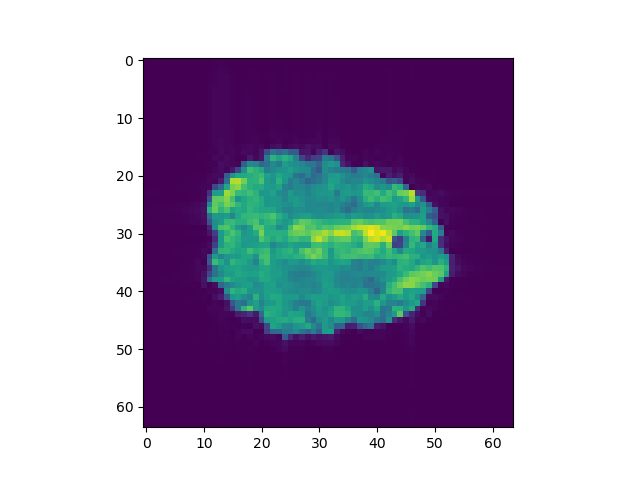

In [68]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(np.abs(test_cpu[500, :, :, 20]))
plt.show()

In [ ]:
# Apply fft and cropping
crop_center_shape = (64, 64, 40)
out_sampling_1 = sampling_model.apply_cartesian_FFT(compute_on_device="gpu", return_on_device="cpu", crop_center_k_space_xyz=crop_center_shape, rechunking=True)

In [ ]:
out_sampling_1[0,0:1000,:,:,:]

In [ ]:
# 1) Start Cluster
cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
#cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
#WORKS on DL: 
cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")

#------------------------------------------------
Console.start_timer()

#test_gpu = test_graph[0,0:1000,:,:,:].compute()
test_gpu = out_sampling_1[0,0:1000,:,:,:].compute()


Console.stop_timer()
#------------------------------------------------

# 3) Close client and cluster
cluster.close()

In [ ]:
# 1) Start Cluster
cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
#cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
#WORKS on DL: 
cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")

#------------------------------------------------
Console.start_timer()

#test_gpu = test_graph[0,0:1000,:,:,:].compute()
test_gpu = out_sampling_1[0,0:1000,:,:,:].compute()


Console.stop_timer()
#------------------------------------------------

# 3) Close client and cluster
cluster.close()

In [ ]:
np.abs(test_gpu[100,:,:, 20])

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.imshow(np.abs(test_gpu[100,:,:, 20]))
plt.savefig("slice_100_20.png", dpi=200, bbox_inches="tight")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(np.abs(test_gpu[0,:,:,40]))
plt.show()

In [ ]:
### TODO: Next step is coil combination!?

# Cartesian k-Space & Cropping

In [ ]:
crop_center_shape = (64, 64, 40)

g.add_node(name="Cartesian Fourier Transformation",
           text=f"To bring the 4D volume of each coil to k-space and to spatially crop the center for each to {crop_center_shape}.", 
           cluster="k-space")

computational_graph_3 = sampling_model.cartesian_FFT(volumes_with_coil_sensitivity_maps=computational_graph_2,
                                                     crop_center_shape=crop_center_shape,
                                                     compute_on_device='cuda',  # cuda works with 100_000
                                                     return_on_device='cuda')   # cpu works with 100_000

#### <span style="color:red">!!! The following step is just a test regarding selecting the only the desired GPU (not utilise GPU = as currently)</span>

In [ ]:
# 1) Start Cluster
cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
#cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
#WORKS on DL: 
cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")

#------------------------------------------------
Console.start_timer()

test_gpu = computational_graph_3[0].compute()


Console.stop_timer()
#------------------------------------------------

# 3) Close client and cluster
cluster.close()

# Back to i-Space (IFFT)

In [ ]:
g.add_node(name="Cartesian Fourier Transformation",
           text=f"To bring the 4D volume of each coil to k-space and to spatially crop the center for each to {crop_center_shape}.", 
           cluster="k-space")

computational_graph_4 = sampling_model.cartesian_IFFT(volumes_cartesian_k_space=computational_graph_3,
                                                      compute_on_device='cuda',   # cuda work with 100_000
                                                      return_on_device='cuda')    # cpu work with 100_000

In [ ]:
interpolate_sensitivity_maps = (32,) + crop_center_shape

g.add_node(name="Interpolate coil sensitivity (ifft)", text=f"Interpolate coil sensitivity maps to {interpolate_sensitivity_maps}. For Coil combination after IFFT.", cluster="Interpolation", width=0.5)

coil_sensitivity_maps_resized = coil_sensitivity_maps_loader.interpolate(target_size=interpolate_sensitivity_maps, order=2, compute_on_device='cuda', gpu_index=target_gpu_smaller_tasks, return_on_device='cuda') # TODO TODO TODO TODO

In [ ]:
computational_graph_4

In [ ]:
import cupy as cp
import dask
import dask.array as da


graphs_da = da.stack([da.asarray(g) for g in computational_graph_4], axis=0)   # (32,1536,64,64,40)
coils_da  = da.stack([da.asarray(c) for c in coil_sensitivity_maps_resized], axis=0)  # (32,64,64,40)

# IMPORTANT: make coils broadcast over the 1536 dimension
coils_da_b = coils_da[:, None, ...]  # (32,1,64,64,40)

num_da = da.sum(graphs_da * da.conj(coils_da_b), axis=0)   # -> (1536,64,64,40)
den_da = da.sum(da.absolute(coils_da) ** 2, axis=0)        # -> (64,64,40)

In [ ]:
text = f""" =====================================================================================================
        Step: Compute the forward process
        
        Description: `This computes the sampling model and also includes a forward process to check the data.`
            [x] 1. Bring to k-space (thus FFT to dimensions 1,2,3 excluding 0)
            [x] 2. Crop the center to {crop_center_shape}
            [x] 3. IFFT back to image space
            [x] 4. Interpolate coil sensitivity maps to {crop_center_shape}
            [x] 5. Could combination with resized coil sensitivity maps
        
        """

g.add_node(name="Compute the forward process",
           text=text,
           cluster="GPU cluster",
           title_colour="green")


# Start cluster again!
# 1) Start Cluster
cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
#cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
#WORKS on DL: 
cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")

#------------------------------------------------
Console.start_timer()

num, den = dask.compute(num_da, den_da) 

num = cp.asnumpy(num) if isinstance(num, cp.ndarray) else num
den = cp.asnumpy(den) if isinstance(den, cp.ndarray) else den

Console.stop_timer()
#------------------------------------------------

# 3) Close client and cluster
cluster.close()
# 4) Convert again to dask array
computational_graph_1 = da.from_array(volume_computed, chunks=block_size)

#### <span style="color:red">Signal height is too much?</span>

In [ ]:
result = num/den
result.shape

test_fid = FID()

for i in range(5,35,5):
    test_fid += FID(
        signal=result[:,i,i,i], 
        time=loaded_fid.time, 
        name=[f"test FID [:,{i},{i},{i}]"])

#test_fid = FID(signal=result[:,20,20,20], time=loaded_fid.time, name=["test FID 1"])
test_fid.plot(additional_description="The Signal of the FID \n of the respective spactial position \n after cartesian FFT, cropping, IFFT and \n coil combination. \n Volume shape: [1536x64x64x40]", plot_offset=10000)

In [ ]:
#result

In [ ]:
#plt.plot(result[:, 20,20,20].compute())

#result.shape

In [ ]:
g.create()
g.save("cartesian__easy_graph_test_2")

In [ ]:
import dask, distributed, bokeh
import dask_labextension

print("dask:", dask.__version__)
print("distributed:", distributed.__version__)
print("bokeh:", bokeh.__version__)
print("dask_labextension:", dask_labextension.__version__)


In [ ]:
!jupyter lab --version